# Quick walk-through of colormapping a scatter plot

# import packages and functions

In [1]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py

/Users/akbaskind/Documents/Python Scripts/phyto


In [2]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from importlib import reload
import warnings
warnings.filterwarnings('ignore')

# Pull data from [spreadsheet](https://docs.google.com/spreadsheets/d/1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10/edit#gid=0)

- opening all the datasets in the spreadsheet all at once
- `hydrocat620`
- `hydrocat720`
- `MV`
- `QP`

In [3]:
#The scope is always look like this so we did not need to change anything

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Spreadsheet key
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

# Worksheet keys
wks_hydrocat620 = 'Hydrocat 620'
wks_hydrocat720 = 'Hydrocat 720'
wks_MV = 'MV'
wks_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

## HYDROCAT 620
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat620)
values = sheet.get_all_values()
hydrocat620 = pd.DataFrame(values[1:], columns = values[0])


## HYDROCAT 720
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat720)
values = sheet.get_all_values()
hydrocat720 = pd.DataFrame(values[1:], columns = values[0])

## MV
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_MV)
values = sheet.get_all_values()
MV = pd.DataFrame(values[1:], columns = values[0])

## QP
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_QP)
values = sheet.get_all_values()
QP = pd.DataFrame(values[1:], columns = values[0])

## Correct data types

In [8]:
for k in hydrocat620.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat620[k] = pd.to_datetime(hydrocat620[k])
    else:
        hydrocat620[k] = pd.to_numeric(hydrocat620[k])

for k in hydrocat720.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat720[k] = pd.to_datetime(hydrocat720[k])
    else:
        hydrocat720[k] = pd.to_numeric(hydrocat720[k])
        
for k in QP.keys():
    if k == 'DateTime' or k == 'time':
        QP[k] = pd.to_datetime(QP[k])
    else:
        QP[k] = pd.to_numeric(QP[k])
        
for k in MV.keys():
    if k == 'DateTime' or k == 'time':
        MV[k] = pd.to_datetime(MV[k])
    else:
        MV[k] = pd.to_numeric(MV[k])

# JOURNEY TO COLORMAPPED SCATTER PLOT
## Step 1. Start with a scatter plot.

Let's use the MV dataset for now.

In [10]:
MV.keys()

Index(['DateTime', 'time', 'ordinal_time', 'surface Temp', 'surface Salinity',
       'surface DO Conc', 'pH total'],
      dtype='object')

Text(0.5, 1.0, 'Small Plot Title')

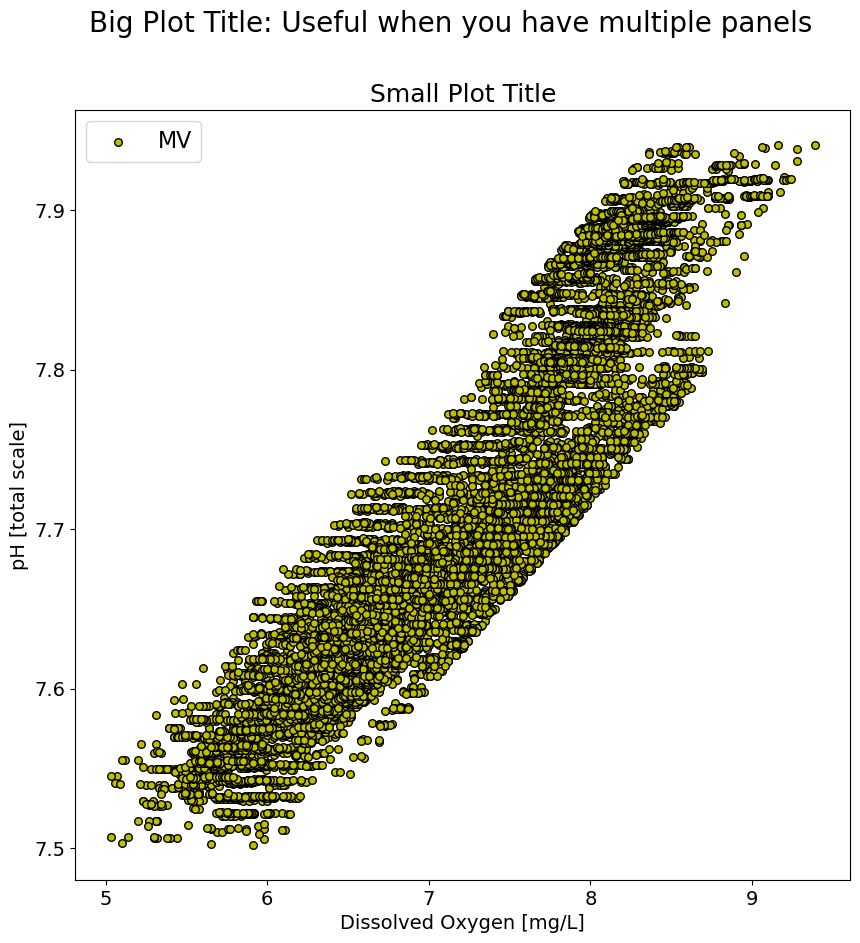

In [24]:
fig, ax = plt.subplots(figsize = [10,10])

# Adding 'label' to the end of this gives the plotted points a legend entry
# So calling ax.legend() will have all the appropriate data
ax.scatter(MV['surface DO Conc'], MV['pH total'], s = 30, edgecolors = 'k', facecolors = 'y', label = 'MV')

# Note how I can change the axis font size with `fontsize`
ax.set_xlabel('Dissolved Oxygen [mg/L]', fontsize = 14)
ax.set_ylabel('pH [total scale]', fontsize = 14)

# Similarly, I can change the tick label size with `labelsize`
ax.tick_params('x',labelsize = 14)
ax.tick_params('y',labelsize = 14)

ax.legend(fontsize = 16)

fig.suptitle('Big Plot Title: Useful when you have multiple panels', fontsize=20)
ax.set_title('Small Plot Title', fontsize = 18)

## Step 2. A bit more sophisticated by colormapping temperature onto the plot

We need to do a few things to get this colormap to work.

1. When we create our figure object, we need to name it so we can reference it later. I called mine `im`.
2. `ax.scatter()` takes an argument `c` for color. You can check out the [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) for more info. It can take a few different inputs. The one that matters to us is "a scalar or sequence of n numbers to be mapped to colors using cmap and norm." Our array of temperature works for that!
3. Since our scatter plot is colormapped, we need a colorbar. This is why we named our figure object. We create the colorbar by calling `plt.colorbar()`. We need to specify what this colorbar corresponds to, so our first argument is the name of the figure it goes to. Further, we need to specify the axis in the keyword argument `ax = your_axis_name`.


Text(0.5, 1.0, 'A slightly more sophisticated plot')

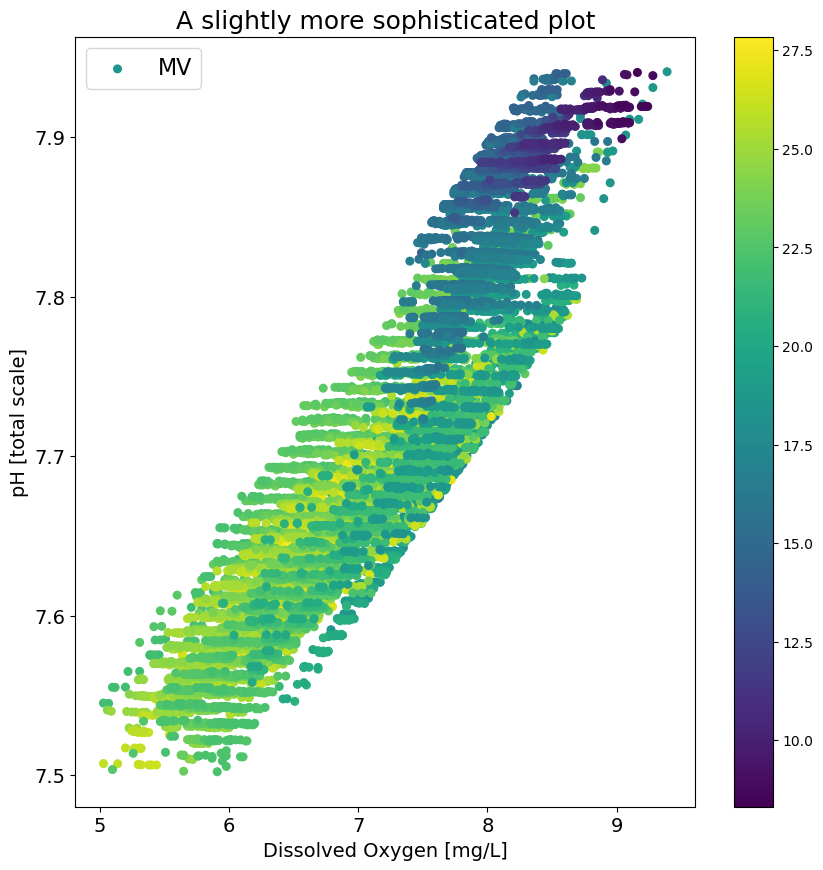

In [35]:
fig, AX = plt.subplots(figsize = [10,10])

# Set the plot equal to some variable name so you can call that name later
im = AX.scatter(MV['surface DO Conc'], MV['pH total'], s = 30, c = MV['surface Temp'], label = 'MV')

# When creating the colorbar, call the figure object (which we called 'im')
# and declare the axis the colorbar belongs to
cbar = plt.colorbar(im, ax = AX)

# axis labels
AX.set_xlabel('Dissolved Oxygen [mg/L]', fontsize = 14)
AX.set_ylabel('pH [total scale]', fontsize = 14)

# change the tick label size
AX.tick_params('x',labelsize = 14)
AX.tick_params('y',labelsize = 14)

AX.legend(fontsize = 16)

AX.set_title('A slightly more sophisticated plot', fontsize = 18)

## Step 3. Refining our colormapped scatter plot

We might want to change a few things here, to take this plot to the next level. Personally, I am going to change a few things.

1. The default colormap is `viridis`. This is a GREAT colormap for most things. `viridis` is a "perceptually uniform sequential colormap" which is S-tier. However, when I plot things like temperature, I often choose a colormap that corresponds with our need for cooler temps to be bluer and warmer temps to be redder. Some good colormap options for this are `RdBu_r` (which stands for red-blue reverse) or `coolwarm`. To change your colormap, just add the keyword argument `cmap = your_colormap` to the `scatter()` function. You can check out other colormaps [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

2. Adding a label to our colorbar would be super helpful. Label this like you would any other axis. Give the quantity name (in this case temperature) and provide units. We can use the `rotation` keyword argument to rotate the label whatever way we would like. We can also change the amount of space between the label and the colorbar using the keyword argument `labelpad`.

3. Sometimes, Python won't guess what limits we want on the colorbar perfectly. In our last iteration, the colorbar went from ~7.5degC to 27.5degC. Sure, this may be fine if this plot stood alone, but let's remember MV only has summer data, and our other sensors have winter data as well. This is to say, the other sensors will show colder temperatures, and if we want all of our colorbars to match each other (we definitely want that), we need consistently colorbar limits. So I'm going to guess setting the colorbar to go from 0degC to 30degC will encapsulate all the temperatures we will see across all the sensors. To set that, I will add the keyword arguments `vmin = your_min_value` and `vmax = your_max_value` to the `scatter()` function.

4. What if we want to change where the ticks are on our colorbar? Or change the labels of the ticks? We can do that! We can specify where the ticks are using the `ticks` keyword argument in the `colorbar()` function. The tick labels will automatically be the exact same as the numeric values (so in this case, automatically the labels will read 0, 10, 20, and 30. But we can reset those using `cbar.ax.set_yticklabels([labels_array])`. Just to demonstrate, I have labeled some of my ticks COLD and HOT.

Text(0.5, 1.0, 'A slightly more sophisticated plot')

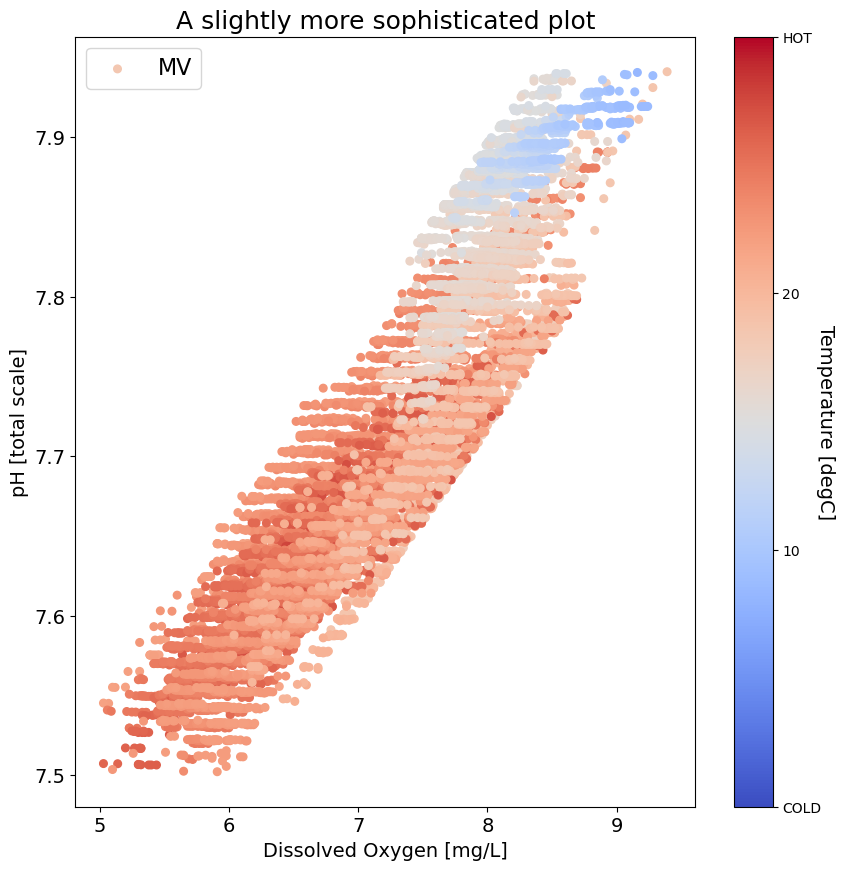

In [46]:
fig, AX = plt.subplots(figsize = [10,10])

# Set the plot equal to some variable name so you can call that name later
im = AX.scatter(MV['surface DO Conc'], MV['pH total'],
                # Change colormap
                s = 30, c = MV['surface Temp'], cmap = 'coolwarm',
                # Added colormap limits
                vmin = 0, vmax = 30, label = 'MV')

# Create colorbar
# Specify where our ticks are with 'ticks'
cbar = fig.colorbar(im, ax = AX, ticks=[0, 10, 20, 30])

# Add label to colorbar. Note the fontsize change
# The rotation argument just flips the label direction 
cbar.set_label('Temperature [degC]', fontsize = 14, rotation = 270, labelpad = 10)

# Colorbar ticks
cbar.ax.set_yticklabels(['COLD','10','20','HOT'])

# axis labels
AX.set_xlabel('Dissolved Oxygen [mg/L]', fontsize = 14)
AX.set_ylabel('pH [total scale]', fontsize = 14)

# change the tick label size
AX.tick_params('x',labelsize = 14)
AX.tick_params('y',labelsize = 14)

AX.legend(fontsize = 16)

AX.set_title('A slightly more sophisticated plot', fontsize = 18)




## Step 4. Let's make a couple of these colormapped scatter plots!

Text(0.5, 0.98, 'Narr. Bay Fixed Station Monitoring Network MV')

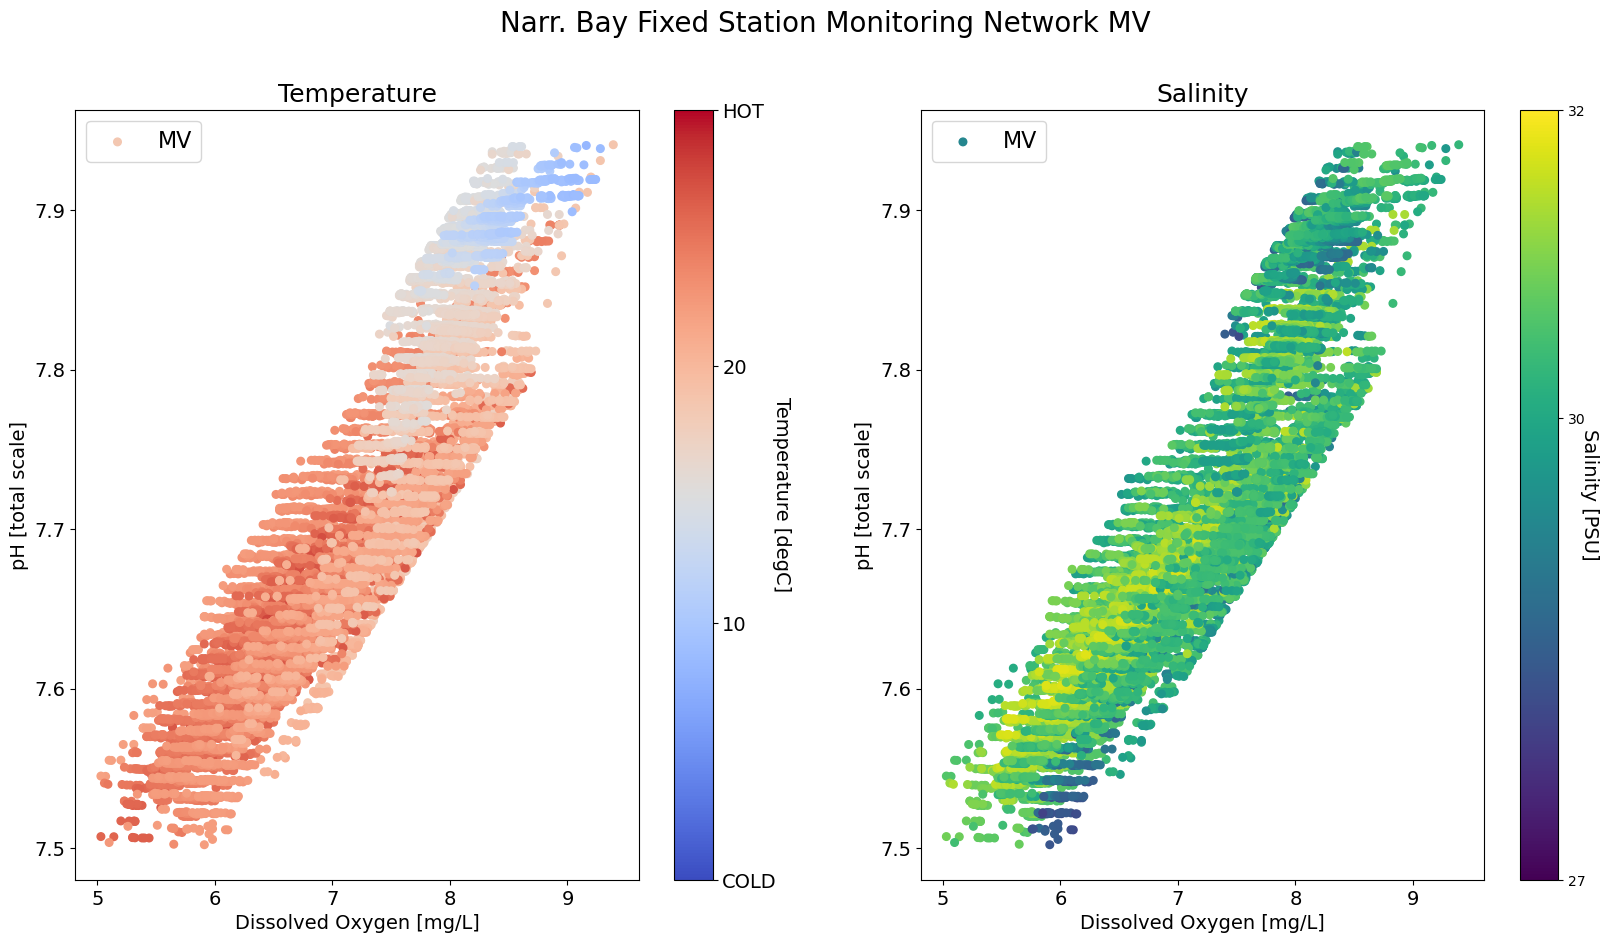

In [54]:
fig, axarr = plt.subplots(ncols = 2, figsize = [20,10])

axarr = axarr.flatten()

# # COLORMAPPED TO TEMPERATURE -------------------------------------------------------------
AX0 = axarr[0]

# Set the plot equal to some variable name so you can call that name later
im0 = AX0.scatter(MV['surface DO Conc'], MV['pH total'],
                # Change colormap
                s = 30, c = MV['surface Temp'], cmap = 'coolwarm',
                # Added colormap limits
                vmin = 0, vmax = 30, label = 'MV')

# Create colorbar
# Specify where our ticks are with 'ticks'
cbar0 = fig.colorbar(im0, ax = AX0, ticks=[0, 10, 20, 30])

# Add label to colorbar. Note the fontsize change
# The rotation argument just flips the label direction 
cbar0.set_label('Temperature [degC]', fontsize = 14, rotation = 270, labelpad = 10)

# Colorbar ticks
cbar0.ax.set_yticklabels(['COLD','10','20','HOT'], fontsize = 14)

# axis labels
AX0.set_xlabel('Dissolved Oxygen [mg/L]', fontsize = 14)
AX0.set_ylabel('pH [total scale]', fontsize = 14)

# change the tick label size
AX0.tick_params('x',labelsize = 14)
AX0.tick_params('y',labelsize = 14)

AX0.legend(fontsize = 16)

AX0.set_title('Temperature', fontsize = 18)

# # COLORMAPPED TO SALINITY -------------------------------------------------------------
AX1 = axarr[1]

# Set the plot equal to some variable name so you can call that name later
im1 = AX1.scatter(MV['surface DO Conc'], MV['pH total'],
                # Change colormap
                s = 30, c = MV['surface Salinity'], cmap = 'viridis',
                # Added colormap limits
                # I selected my min and max just by taking min and max of MV['surface Salinity']
                vmin = 27, vmax = 32, label = 'MV')

# Create colorbar
# Specify where our ticks are with 'ticks'
cbar1 = fig.colorbar(im1, ax = AX1, ticks=[27, 30, 32])

# Add label to colorbar. Note the fontsize change
# The rotation argument just flips the label direction 
cbar1.set_label('Salinity [PSU]', fontsize = 14, rotation = 270, labelpad = 10)

# axis labels
AX1.set_xlabel('Dissolved Oxygen [mg/L]', fontsize = 14)
AX1.set_ylabel('pH [total scale]', fontsize = 14)

# change the tick label size
AX1.tick_params('x',labelsize = 14)
AX1.tick_params('y',labelsize = 14)

AX1.legend(fontsize = 16)

AX1.set_title('Salinity', fontsize = 18)

# # BIG TITLE -------------------------------------------------------------
fig.suptitle('Narr. Bay Fixed Station Monitoring Network MV', fontsize=20)

## Extra step!

There are lots of other things you can do to your colorbars! Check out my plots in [GFDLpresent.ipynb](https://github.com/abby-baskind/YoE/blob/main/GFDLpresent.ipynb) for some other ideas. Here I made the colorbars horizontal and used the `fraction` and `pad` keyword arguments to change the size and location of the colorbars.